# Betting Bot

Making a function to run over predicitons and calculate wins/losses

## Setup

In [ ]:
!git clone https://github.com/guggio/soccer_bets.git

Cloning into 'soccer_bets'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.


### Imports

In [ ]:
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dropout, Dense
from sklearn.preprocessing import RobustScaler

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from  matplotlib.ticker import FuncFormatter

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# trying to make it reproducible according to https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development. 
# Unfortunately does not work when the runtime is reset.

import numpy as np
import tensorflow as tf
import random as python_random
import os

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(42)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(42)

## Loading the data

In [ ]:
dataset_18_19 = 'soccer_bets/data/Bundesliga_18_19_complete_B365.csv'

In [ ]:
data = pd.read_csv(dataset_18_19)

In [ ]:
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A
0,24.08.18,Bayern Munich,Hoffenheim,3,1,H,1.20,7.50,12.00
1,25.08.18,Fortuna Dusseldorf,Augsburg,1,2,A,2.37,3.25,3.00
2,25.08.18,Freiburg,Ein Frankfurt,0,2,A,2.30,3.30,3.25
3,25.08.18,Hertha,Nurnberg,1,0,H,2.04,3.40,3.75
4,25.08.18,M'gladbach,Leverkusen,2,0,H,2.80,3.50,2.45


## Prepare the data

In [ ]:
data['Score'] = data['FTHG'] - data['FTAG']

In [ ]:
# The bundesliga has 18 teams, thus every round consists of 9 games
data['Round'] = np.zeros((len(data),1))

current_round = 1
for row in range(1,len(data)+1):
  data['Round'][row-1] = current_round
  if (row % 9) == 0:
    current_round += 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
teams = list(set(data['HomeTeam'].values)) # creating a list containing every team
n_teams = len(teams) # number of teams
teamToIdx = {t: i for i, t in enumerate(teams)} # our team vocabulary

# assigning the games' home teams their corresponding team id
homeId = [teamToIdx[id] for id in list(data['HomeTeam'].values)]
data['Home_Id'] = homeId #creating a new column for the home team id

# assigning the games' away teams their corresponding team id
awayId = [teamToIdx[id] for id in list(data['AwayTeam'].values)]
data['Away_Id'] = awayId # creating a new row for the away team id

In [ ]:
score_transformer = RobustScaler()

score_transformer = score_transformer.fit(data[['Score']])

data['Score'] = score_transformer.transform(data[['Score']])

In [ ]:
data.head()

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,B365H,B365D,B365A,Score,Round,Home_Id,Away_Id
0,24.08.18,Bayern Munich,Hoffenheim,3,1,H,1.20,7.50,12.00,0.666667,1.0,0,6
1,25.08.18,Fortuna Dusseldorf,Augsburg,1,2,A,2.37,3.25,3.00,-0.333333,1.0,14,13
2,25.08.18,Freiburg,Ein Frankfurt,0,2,A,2.30,3.30,3.25,-0.666667,1.0,3,5
3,25.08.18,Hertha,Nurnberg,1,0,H,2.04,3.40,3.75,0.333333,1.0,4,12
4,25.08.18,M'gladbach,Leverkusen,2,0,H,2.80,3.50,2.45,0.666667,1.0,8,11


## First Modeling and Evaluation
Let's build a LSTM, train it on the first five rounds and determine the required training epochs for the real model afterwards.

In [ ]:
def create_dataset(X, y):
    Xs, ys = [], []
    for i in range(len(X)):
        v = X.iloc[i].values
        Xs.append(v)
        ys.append(y.iloc[i])     
    return np.array(Xs), np.array(ys)

In [ ]:
train_set = data[data['Round'] < 6]
X_train, y_train = create_dataset(train_set[['Home_Id', 'Away_Id']], train_set.Score)

In [ ]:
model = Sequential()
model.add(Embedding(n_teams+1, 9, input_length=2))
model.add(LSTM(units=128, recurrent_dropout=0.2))
model.add(Dropout(rate=0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
history = model.fit(X_train, y_train,         
                  epochs = 25,
                  batch_size=9,
                  validation_split=0.1,
                  shuffle=False)

Epoch 1/25
5/5 [==============================] - 0s 64ms/step - loss: 0.2386 - val_loss: 1.2720
Epoch 2/25
5/5 [==============================] - 0s 11ms/step - loss: 0.2360 - val_loss: 1.2566
Epoch 3/25
5/5 [==============================] - 0s 10ms/step - loss: 0.2342 - val_loss: 1.2421
Epoch 4/25
5/5 [==============================] - 0s 10ms/step - loss: 0.2325 - val_loss: 1.2279
Epoch 5/25
5/5 [==============================] - 0s 10ms/step - loss: 0.2308 - val_loss: 1.2138
Epoch 6/25
5/5 [==============================] - 0s 12ms/step - loss: 0.2289 - val_loss: 1.1992
Epoch 7/25
5/5 [==============================] - 0s 10ms/step - loss: 0.2277 - val_loss: 1.1843
Epoch 8/25
5/5 [==============================] - 0s 10ms/step - loss: 0.2262 - val_loss: 1.1693
Epoch 9/25
5/5 [==============================] - 0s 11ms/step - loss: 0.2236 - val_loss: 1.1537
Epoch 10/25
5/5 [==============================] - 0s 10ms/step - loss: 0.2212 - val_loss: 1.1370
Epoch 11/25
5/5 [============

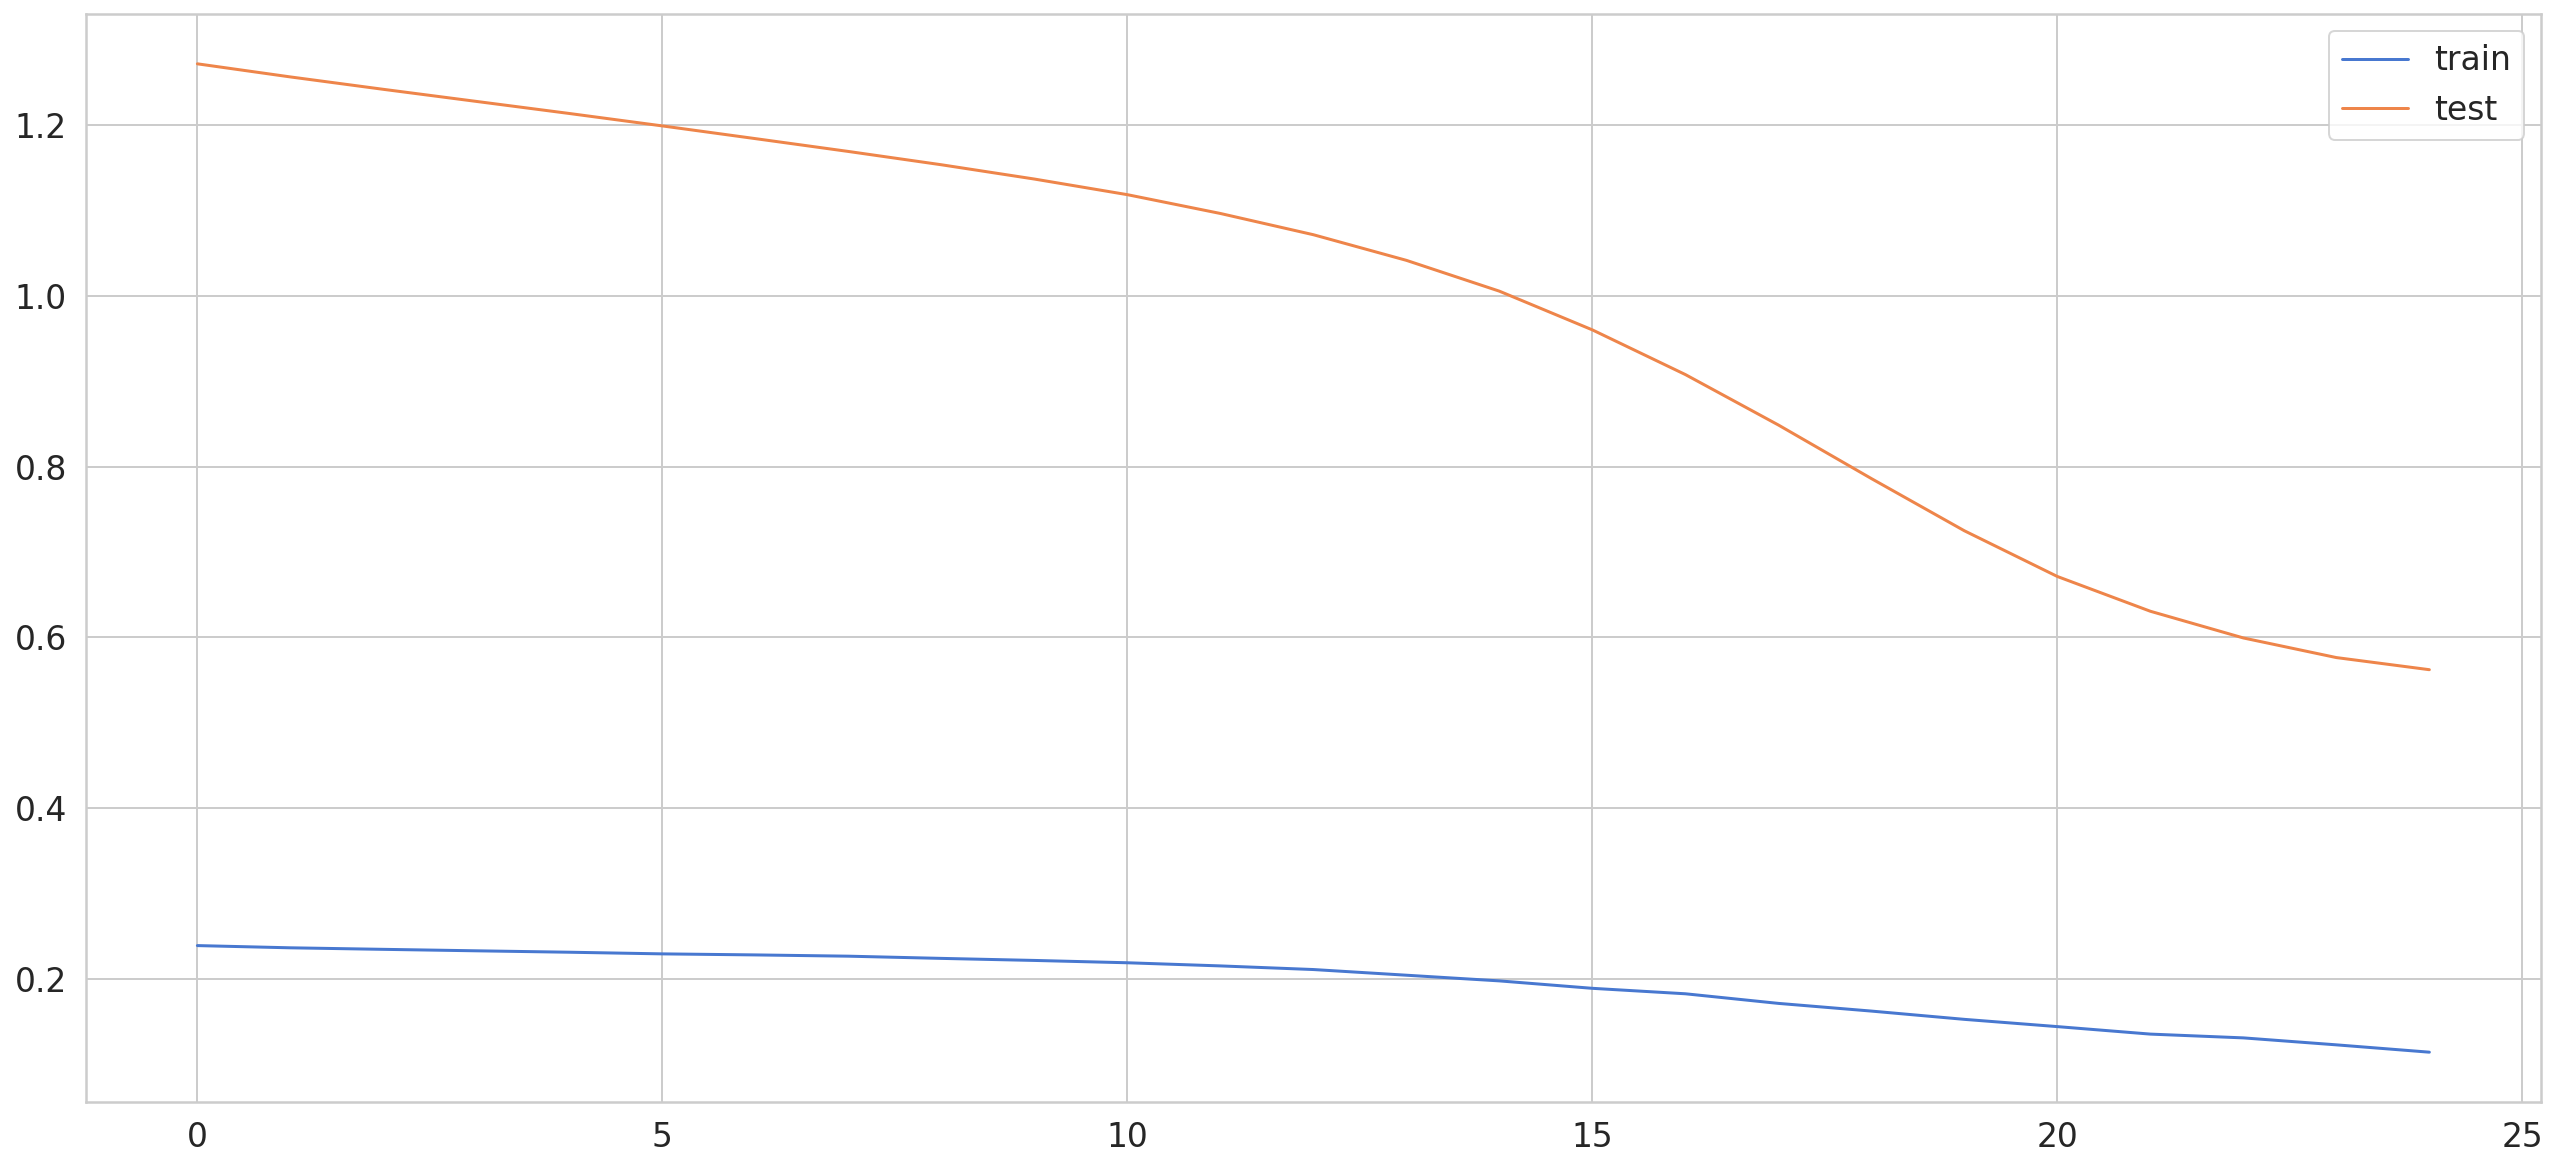

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

## Putting it all together

In [ ]:
def create_dataset(X, y):
    Xs, ys = [], []
    for i in range(len(X)):
        v = X.iloc[i].values
        Xs.append(v)
        ys.append(y.iloc[i])     
    return np.array(Xs), np.array(ys)

In [ ]:
def create_train_test_data(data, round):
  train_set = data[data['Round'] < round]
  test_set = data[data['Round'] == round]
  X_train, y_train = create_dataset(train_set[['Home_Id', 'Away_Id']], train_set.Score)
  X_test, y_test = create_dataset(test_set[['Home_Id', 'Away_Id']], test_set.Score)
  return {'train_set':train_set,'test_set':test_set,'X_train':X_train, 'y_train': y_train, 'X_test':X_test, 'y_test': y_test}

In [ ]:
def create_model (n_teams, lstm_units=128, optimizer='adam', loss='mean_squared_error', dropout_rate=0.2, input_length=2, batchsize=9):
  model = Sequential()
  model.add(Embedding(n_teams+1, batchsize, input_length=input_length))
  model.add(LSTM(units=lstm_units, recurrent_dropout=dropout_rate))
  model.add(Dropout(rate=dropout_rate))
  model.add(Dense(units=1))
  model.compile(optimizer=optimizer, loss=loss)
  return model

In [ ]:
def train_model(model, X, y, epochs=20, batch_size=9):
  history = model.fit(X, y,
                    epochs = epochs,
                    batch_size=batch_size,
                    shuffle=False)
  return history

In [ ]:
def predict_results(model, X):
  y_pred = model.predict(X)
  return y_pred

In [ ]:
def retransform_y_data(y_test, y_pred):
  y_actual = score_transformer.inverse_transform(y_test.reshape(1, -1)).reshape(-1,1)
  y_pred = score_transformer.inverse_transform(y_pred).reshape(-1,1)
  return {'y_actual':y_actual, 'y_pred':y_pred}

In [ ]:
def calculate_bets(prediction_data):
  invested, won = list(), list()

  for i in range(len(prediction_data)):
    # when the model "confidently" predicts a home win
    if prediction_data.prediction.iloc[i] >= 1.1:
      invested.append(1)
      # check if it was actually a home win
      if prediction_data.Score.iloc[i] >= 1.0:
        won.append(prediction_data.B365H.iloc[i])
      else:
        won.append(0)
    
    #when the model "confidently" predicts an away win
    elif prediction_data.prediction.iloc[i] <= -1.1:
      invested.append(1)
      #check if it was actually an away win
      if prediction_data.Score.iloc[i] <= -1.0:
        won.append(prediction_data.B365A.iloc[i])
      else:
        won.append(0)
    else:
      invested.append(0)
      won.append(0)
  return {'invested':invested, 'won':won}

In [ ]:
def create_prediction_dataframe(data:pd.DataFrame, y_actual_pred):
  pred_data = data[['Round','Home_Id', 'Away_Id', 'Score', 'B365H',	'B365D',	'B365A'	]]
  pred_data['Score'] = y_actual_pred['y_actual']
  pred_data['prediction'] = y_actual_pred['y_pred']
  bet_data = calculate_bets(pred_data)
  pred_data['invested'] = bet_data['invested']
  pred_data['won'] = bet_data['won']
  return pred_data

In [ ]:
def beat_the_bookie(data, start_round=6, n_teams=17):
  total_rounds_in_season = n_teams * 2
  calculated_bets = list()
  for i in range(start_round, total_rounds_in_season + 1):
    current_data = create_train_test_data(data, i)
    model = create_model(n_teams)
    history = train_model(model, X=current_data['X_train'], y=current_data['y_train'])
    y_pred = predict_results(model, current_data['X_test'])
    retransformed_y_data = retransform_y_data(current_data['y_test'], y_pred)
    calculated_bets.append(create_prediction_dataframe(current_data['test_set'], retransformed_y_data))
  df = pd.concat(calculated_bets)
  return df

## Let's beat the bookmakers and take a evaluate our performance

In [ ]:
bet_data = beat_the_bookie(data)

Epoch 1/20
5/5 [==============================] - 0s 5ms/step - loss: 0.3528
Epoch 2/20
5/5 [==============================] - 0s 4ms/step - loss: 0.3466
Epoch 3/20
5/5 [==============================] - 0s 4ms/step - loss: 0.3407
Epoch 4/20
5/5 [==============================] - 0s 4ms/step - loss: 0.3377
Epoch 5/20
5/5 [==============================] - 0s 4ms/step - loss: 0.3319
Epoch 6/20
5/5 [==============================] - 0s 4ms/step - loss: 0.3255
Epoch 7/20
5/5 [==============================] - 0s 4ms/step - loss: 0.3227
Epoch 8/20
5/5 [==============================] - 0s 4ms/step - loss: 0.3200
Epoch 9/20
5/5 [==============================] - 0s 4ms/step - loss: 0.3153
Epoch 10/20
5/5 [==============================] - 0s 5ms/step - loss: 0.3087
Epoch 11/20
5/5 [==============================] - 0s 4ms/step - loss: 0.2978
Epoch 12/20
5/5 [==============================] - 0s 4ms/step - loss: 0.2909
Epoch 13/20
5/5 [==============================] - 0s 4ms/step - loss: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
6/6 [==============================] - 0s 6ms/step - loss: 0.3710
Epoch 2/20
6/6 [==============================] - 0s 5ms/step - loss: 0.3612
Epoch 3/20
6/6 [==============================] - 0s 4ms/step - loss: 0.3525
Epoch 4/20
6/6 [==============================] - 0s 4ms/step - loss: 0.3451
Epoch 5/20
6/6 [==============================] - 0s 4ms/step - loss: 0.3390
Epoch 6/20
6/6 [==============================] - 0s 4ms/step - loss: 0.3326
Epoch 7/20
6/6 [==============================] - 0s 4ms/step - loss: 0.3307
Epoch 8/20
6/6 [==============================] - 0s 4ms/step - loss: 0.3248
Epoch 9/20
6/6 [==============================] - 0s 4ms/step - loss: 0.3177
Epoch 10/20
6/6 [==============================] - 0s 5ms/step - loss: 0.3111
Epoch 11/20
6/6 [==============================] - 0s 4ms/step - loss: 0.3081
Epoch 12/20
6/6 [==============================] - 0s 4ms/step - loss: 0.2953
Epoch 13/20
6/6 [==============================] - 0s 4ms/step - loss: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
7/7 [==============================] - 0s 5ms/step - loss: 0.4194
Epoch 2/20
7/7 [==============================] - 0s 4ms/step - loss: 0.4081
Epoch 3/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3973
Epoch 4/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3876
Epoch 5/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3807
Epoch 6/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3740
Epoch 7/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3690
Epoch 8/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3589
Epoch 9/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3531
Epoch 10/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3419
Epoch 11/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3235
Epoch 12/20
7/7 [==============================] - 0s 4ms/step - loss: 0.3083
Epoch 13/20
7/7 [==============================] - 0s 4ms/step - loss: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
8/8 [==============================] - 0s 5ms/step - loss: 0.4915
Epoch 2/20
8/8 [==============================] - 0s 4ms/step - loss: 0.4815
Epoch 3/20
8/8 [==============================] - 0s 4ms/step - loss: 0.4733
Epoch 4/20
8/8 [==============================] - 0s 4ms/step - loss: 0.4656
Epoch 5/20
8/8 [==============================] - 0s 5ms/step - loss: 0.4614
Epoch 6/20
8/8 [==============================] - 0s 4ms/step - loss: 0.4569
Epoch 7/20
8/8 [==============================] - 0s 4ms/step - loss: 0.4496
Epoch 8/20
8/8 [==============================] - 0s 4ms/step - loss: 0.4424
Epoch 9/20
8/8 [==============================] - 0s 4ms/step - loss: 0.4283
Epoch 10/20
8/8 [==============================] - 0s 4ms/step - loss: 0.4132
Epoch 11/20
8/8 [==============================] - 0s 5ms/step - loss: 0.3958
Epoch 12/20
8/8 [==============================] - 0s 4ms/step - loss: 0.3744
Epoch 13/20
8/8 [==============================] - 0s 4ms/step - loss: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
9/9 [==============================] - 0s 5ms/step - loss: 0.5027
Epoch 2/20
9/9 [==============================] - 0s 4ms/step - loss: 0.4940
Epoch 3/20
9/9 [==============================] - 0s 4ms/step - loss: 0.4888
Epoch 4/20
9/9 [==============================] - 0s 4ms/step - loss: 0.4834
Epoch 5/20
9/9 [==============================] - 0s 4ms/step - loss: 0.4815
Epoch 6/20
9/9 [==============================] - 0s 4ms/step - loss: 0.4742
Epoch 7/20
9/9 [==============================] - 0s 4ms/step - loss: 0.4676
Epoch 8/20
9/9 [==============================] - 0s 4ms/step - loss: 0.4580
Epoch 9/20
9/9 [==============================] - 0s 4ms/step - loss: 0.4423
Epoch 10/20
9/9 [==============================] - 0s 4ms/step - loss: 0.4230
Epoch 11/20
9/9 [==============================] - 0s 4ms/step - loss: 0.3995
Epoch 12/20
9/9 [==============================] - 0s 4ms/step - loss: 0.3777
Epoch 13/20
9/9 [==============================] - 0s 4ms/step - loss: 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
10/10 [==============================] - 0s 4ms/step - loss: 0.5047
Epoch 2/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4986
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4949
Epoch 4/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4907
Epoch 5/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4849
Epoch 6/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4773
Epoch 7/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4673
Epoch 8/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4513
Epoch 9/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4297
Epoch 10/20
10/10 [==============================] - 0s 4ms/step - loss: 0.4057
Epoch 11/20
10/10 [==============================] - 0s 4ms/step - loss: 0.3840
Epoch 12/20
10/10 [==============================] - 0s 4ms/step - loss: 0.3588
Epoch 13/20
10/10 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
11/11 [==============================] - 0s 4ms/step - loss: 0.5051
Epoch 2/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4976
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4938
Epoch 4/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4894
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4846
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4780
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4677
Epoch 8/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4535
Epoch 9/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4329
Epoch 10/20
11/11 [==============================] - 0s 4ms/step - loss: 0.4077
Epoch 11/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3887
Epoch 12/20
11/11 [==============================] - 0s 4ms/step - loss: 0.3694
Epoch 13/20
11/11 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
12/12 [==============================] - 0s 5ms/step - loss: 0.4894
Epoch 2/20
12/12 [==============================] - 0s 5ms/step - loss: 0.4810
Epoch 3/20
12/12 [==============================] - 0s 4ms/step - loss: 0.4762
Epoch 4/20
12/12 [==============================] - 0s 4ms/step - loss: 0.4728
Epoch 5/20
12/12 [==============================] - 0s 4ms/step - loss: 0.4663
Epoch 6/20
12/12 [==============================] - 0s 4ms/step - loss: 0.4599
Epoch 7/20
12/12 [==============================] - 0s 4ms/step - loss: 0.4480
Epoch 8/20
12/12 [==============================] - 0s 4ms/step - loss: 0.4358
Epoch 9/20
12/12 [==============================] - 0s 4ms/step - loss: 0.4153
Epoch 10/20
12/12 [==============================] - 0s 4ms/step - loss: 0.3990
Epoch 11/20
12/12 [==============================] - 0s 4ms/step - loss: 0.3851
Epoch 12/20
12/12 [==============================] - 0s 4ms/step - loss: 0.3728
Epoch 13/20
12/12 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
13/13 [==============================] - 0s 5ms/step - loss: 0.4677
Epoch 2/20
13/13 [==============================] - 0s 4ms/step - loss: 0.4607
Epoch 3/20
13/13 [==============================] - 0s 4ms/step - loss: 0.4572
Epoch 4/20
13/13 [==============================] - 0s 5ms/step - loss: 0.4522
Epoch 5/20
13/13 [==============================] - 0s 4ms/step - loss: 0.4494
Epoch 6/20
13/13 [==============================] - 0s 4ms/step - loss: 0.4432
Epoch 7/20
13/13 [==============================] - 0s 5ms/step - loss: 0.4346
Epoch 8/20
13/13 [==============================] - 0s 4ms/step - loss: 0.4224
Epoch 9/20
13/13 [==============================] - 0s 5ms/step - loss: 0.4070
Epoch 10/20
13/13 [==============================] - 0s 4ms/step - loss: 0.3822
Epoch 11/20
13/13 [==============================] - 0s 4ms/step - loss: 0.3576
Epoch 12/20
13/13 [==============================] - 0s 5ms/step - loss: 0.3332
Epoch 13/20
13/13 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
14/14 [==============================] - 0s 6ms/step - loss: 0.4610
Epoch 2/20
14/14 [==============================] - 0s 4ms/step - loss: 0.4504
Epoch 3/20
14/14 [==============================] - 0s 4ms/step - loss: 0.4446
Epoch 4/20
14/14 [==============================] - 0s 4ms/step - loss: 0.4378
Epoch 5/20
14/14 [==============================] - 0s 4ms/step - loss: 0.4317
Epoch 6/20
14/14 [==============================] - 0s 4ms/step - loss: 0.4224
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - loss: 0.4095
Epoch 8/20
14/14 [==============================] - 0s 4ms/step - loss: 0.3910
Epoch 9/20
14/14 [==============================] - 0s 4ms/step - loss: 0.3737
Epoch 10/20
14/14 [==============================] - 0s 4ms/step - loss: 0.3508
Epoch 11/20
14/14 [==============================] - 0s 4ms/step - loss: 0.3330
Epoch 12/20
14/14 [==============================] - 0s 5ms/step - loss: 0.3082
Epoch 13/20
14/14 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
15/15 [==============================] - 0s 5ms/step - loss: 0.4609
Epoch 2/20
15/15 [==============================] - 0s 4ms/step - loss: 0.4514
Epoch 3/20
15/15 [==============================] - 0s 4ms/step - loss: 0.4460
Epoch 4/20
15/15 [==============================] - 0s 4ms/step - loss: 0.4416
Epoch 5/20
15/15 [==============================] - 0s 4ms/step - loss: 0.4344
Epoch 6/20
15/15 [==============================] - 0s 5ms/step - loss: 0.4217
Epoch 7/20
15/15 [==============================] - 0s 4ms/step - loss: 0.4021
Epoch 8/20
15/15 [==============================] - 0s 4ms/step - loss: 0.3764
Epoch 9/20
15/15 [==============================] - 0s 5ms/step - loss: 0.3473
Epoch 10/20
15/15 [==============================] - 0s 4ms/step - loss: 0.3346
Epoch 11/20
15/15 [==============================] - 0s 4ms/step - loss: 0.3233
Epoch 12/20
15/15 [==============================] - 0s 5ms/step - loss: 0.3120
Epoch 13/20
15/15 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
16/16 [==============================] - 0s 5ms/step - loss: 0.4386
Epoch 2/20
16/16 [==============================] - 0s 4ms/step - loss: 0.4269
Epoch 3/20
16/16 [==============================] - 0s 4ms/step - loss: 0.4190
Epoch 4/20
16/16 [==============================] - 0s 4ms/step - loss: 0.4125
Epoch 5/20
16/16 [==============================] - 0s 4ms/step - loss: 0.4038
Epoch 6/20
16/16 [==============================] - 0s 5ms/step - loss: 0.3881
Epoch 7/20
16/16 [==============================] - 0s 4ms/step - loss: 0.3665
Epoch 8/20
16/16 [==============================] - 0s 4ms/step - loss: 0.3393
Epoch 9/20
16/16 [==============================] - 0s 4ms/step - loss: 0.3147
Epoch 10/20
16/16 [==============================] - 0s 4ms/step - loss: 0.2926
Epoch 11/20
16/16 [==============================] - 0s 4ms/step - loss: 0.2752
Epoch 12/20
16/16 [==============================] - 0s 4ms/step - loss: 0.2677
Epoch 13/20
16/16 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4305
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4216
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4180
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4139
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.4066
Epoch 6/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3921
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3736
Epoch 8/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3532
Epoch 9/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3397
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3309
Epoch 11/20
17/17 [==============================] - 0s 5ms/step - loss: 0.3231
Epoch 12/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3100
Epoch 13/20
17/17 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
18/18 [==============================] - 0s 5ms/step - loss: 0.4198
Epoch 2/20
18/18 [==============================] - 0s 4ms/step - loss: 0.4130
Epoch 3/20
18/18 [==============================] - 0s 4ms/step - loss: 0.4087
Epoch 4/20
18/18 [==============================] - 0s 4ms/step - loss: 0.4024
Epoch 5/20
18/18 [==============================] - 0s 4ms/step - loss: 0.3907
Epoch 6/20
18/18 [==============================] - 0s 5ms/step - loss: 0.3735
Epoch 7/20
18/18 [==============================] - 0s 4ms/step - loss: 0.3448
Epoch 8/20
18/18 [==============================] - 0s 4ms/step - loss: 0.3147
Epoch 9/20
18/18 [==============================] - 0s 4ms/step - loss: 0.2938
Epoch 10/20
18/18 [==============================] - 0s 4ms/step - loss: 0.2774
Epoch 11/20
18/18 [==============================] - 0s 4ms/step - loss: 0.2629
Epoch 12/20
18/18 [==============================] - 0s 4ms/step - loss: 0.2602
Epoch 13/20
18/18 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
19/19 [==============================] - 0s 5ms/step - loss: 0.4365
Epoch 2/20
19/19 [==============================] - 0s 4ms/step - loss: 0.4302
Epoch 3/20
19/19 [==============================] - 0s 4ms/step - loss: 0.4261
Epoch 4/20
19/19 [==============================] - 0s 4ms/step - loss: 0.4201
Epoch 5/20
19/19 [==============================] - 0s 5ms/step - loss: 0.4068
Epoch 6/20
19/19 [==============================] - 0s 4ms/step - loss: 0.3825
Epoch 7/20
19/19 [==============================] - 0s 5ms/step - loss: 0.3384
Epoch 8/20
19/19 [==============================] - 0s 4ms/step - loss: 0.3025
Epoch 9/20
19/19 [==============================] - 0s 4ms/step - loss: 0.2797
Epoch 10/20
19/19 [==============================] - 0s 4ms/step - loss: 0.2684
Epoch 11/20
19/19 [==============================] - 0s 5ms/step - loss: 0.2664
Epoch 12/20
19/19 [==============================] - 0s 4ms/step - loss: 0.2568
Epoch 13/20
19/19 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
20/20 [==============================] - 0s 4ms/step - loss: 0.4317
Epoch 2/20
20/20 [==============================] - 0s 4ms/step - loss: 0.4263
Epoch 3/20
20/20 [==============================] - 0s 4ms/step - loss: 0.4226
Epoch 4/20
20/20 [==============================] - 0s 4ms/step - loss: 0.4178
Epoch 5/20
20/20 [==============================] - 0s 4ms/step - loss: 0.4109
Epoch 6/20
20/20 [==============================] - 0s 4ms/step - loss: 0.3983
Epoch 7/20
20/20 [==============================] - 0s 4ms/step - loss: 0.3776
Epoch 8/20
20/20 [==============================] - 0s 5ms/step - loss: 0.3504
Epoch 9/20
20/20 [==============================] - 0s 4ms/step - loss: 0.3222
Epoch 10/20
20/20 [==============================] - 0s 4ms/step - loss: 0.3017
Epoch 11/20
20/20 [==============================] - 0s 4ms/step - loss: 0.2941
Epoch 12/20
20/20 [==============================] - 0s 4ms/step - loss: 0.2803
Epoch 13/20
20/20 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
21/21 [==============================] - 0s 4ms/step - loss: 0.4445
Epoch 2/20
21/21 [==============================] - 0s 4ms/step - loss: 0.4385
Epoch 3/20
21/21 [==============================] - 0s 4ms/step - loss: 0.4343
Epoch 4/20
21/21 [==============================] - 0s 4ms/step - loss: 0.4290
Epoch 5/20
21/21 [==============================] - 0s 4ms/step - loss: 0.4225
Epoch 6/20
21/21 [==============================] - 0s 5ms/step - loss: 0.4089
Epoch 7/20
21/21 [==============================] - 0s 4ms/step - loss: 0.3872
Epoch 8/20
21/21 [==============================] - 0s 4ms/step - loss: 0.3555
Epoch 9/20
21/21 [==============================] - 0s 4ms/step - loss: 0.3268
Epoch 10/20
21/21 [==============================] - 0s 4ms/step - loss: 0.3032
Epoch 11/20
21/21 [==============================] - 0s 5ms/step - loss: 0.2976
Epoch 12/20
21/21 [==============================] - 0s 4ms/step - loss: 0.2881
Epoch 13/20
21/21 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
22/22 [==============================] - 0s 4ms/step - loss: 0.4384
Epoch 2/20
22/22 [==============================] - 0s 4ms/step - loss: 0.4326
Epoch 3/20
22/22 [==============================] - 0s 5ms/step - loss: 0.4282
Epoch 4/20
22/22 [==============================] - 0s 4ms/step - loss: 0.4205
Epoch 5/20
22/22 [==============================] - 0s 4ms/step - loss: 0.4023
Epoch 6/20
22/22 [==============================] - 0s 4ms/step - loss: 0.3669
Epoch 7/20
22/22 [==============================] - 0s 4ms/step - loss: 0.3249
Epoch 8/20
22/22 [==============================] - 0s 4ms/step - loss: 0.2999
Epoch 9/20
22/22 [==============================] - 0s 4ms/step - loss: 0.2802
Epoch 10/20
22/22 [==============================] - 0s 4ms/step - loss: 0.2768
Epoch 11/20
22/22 [==============================] - 0s 4ms/step - loss: 0.2740
Epoch 12/20
22/22 [==============================] - 0s 4ms/step - loss: 0.2711
Epoch 13/20
22/22 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
23/23 [==============================] - 0s 4ms/step - loss: 0.4438
Epoch 2/20
23/23 [==============================] - 0s 4ms/step - loss: 0.4382
Epoch 3/20
23/23 [==============================] - 0s 4ms/step - loss: 0.4348
Epoch 4/20
23/23 [==============================] - 0s 4ms/step - loss: 0.4312
Epoch 5/20
23/23 [==============================] - 0s 4ms/step - loss: 0.4225
Epoch 6/20
23/23 [==============================] - 0s 4ms/step - loss: 0.4018
Epoch 7/20
23/23 [==============================] - 0s 4ms/step - loss: 0.3706
Epoch 8/20
23/23 [==============================] - 0s 4ms/step - loss: 0.3374
Epoch 9/20
23/23 [==============================] - 0s 5ms/step - loss: 0.3064
Epoch 10/20
23/23 [==============================] - 0s 4ms/step - loss: 0.2871
Epoch 11/20
23/23 [==============================] - 0s 4ms/step - loss: 0.2868
Epoch 12/20
23/23 [==============================] - 0s 4ms/step - loss: 0.2837
Epoch 13/20
23/23 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
24/24 [==============================] - 0s 4ms/step - loss: 0.4543
Epoch 2/20
24/24 [==============================] - 0s 4ms/step - loss: 0.4480
Epoch 3/20
24/24 [==============================] - 0s 4ms/step - loss: 0.4451
Epoch 4/20
24/24 [==============================] - 0s 4ms/step - loss: 0.4390
Epoch 5/20
24/24 [==============================] - 0s 4ms/step - loss: 0.4232
Epoch 6/20
24/24 [==============================] - 0s 4ms/step - loss: 0.3837
Epoch 7/20
24/24 [==============================] - 0s 4ms/step - loss: 0.3328
Epoch 8/20
24/24 [==============================] - 0s 5ms/step - loss: 0.3131
Epoch 9/20
24/24 [==============================] - 0s 5ms/step - loss: 0.2995
Epoch 10/20
24/24 [==============================] - 0s 4ms/step - loss: 0.3001
Epoch 11/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2978
Epoch 12/20
24/24 [==============================] - 0s 4ms/step - loss: 0.2969
Epoch 13/20
24/24 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
25/25 [==============================] - 0s 5ms/step - loss: 0.4637
Epoch 2/20
25/25 [==============================] - 0s 5ms/step - loss: 0.4583
Epoch 3/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4565
Epoch 4/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4546
Epoch 5/20
25/25 [==============================] - 0s 4ms/step - loss: 0.4482
Epoch 6/20
25/25 [==============================] - 0s 5ms/step - loss: 0.4314
Epoch 7/20
25/25 [==============================] - 0s 4ms/step - loss: 0.3919
Epoch 8/20
25/25 [==============================] - 0s 4ms/step - loss: 0.3462
Epoch 9/20
25/25 [==============================] - 0s 5ms/step - loss: 0.3248
Epoch 10/20
25/25 [==============================] - 0s 4ms/step - loss: 0.3130
Epoch 11/20
25/25 [==============================] - 0s 4ms/step - loss: 0.3068
Epoch 12/20
25/25 [==============================] - 0s 4ms/step - loss: 0.3063
Epoch 13/20
25/25 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
26/26 [==============================] - 0s 5ms/step - loss: 0.4711
Epoch 2/20
26/26 [==============================] - 0s 4ms/step - loss: 0.4644
Epoch 3/20
26/26 [==============================] - 0s 4ms/step - loss: 0.4612
Epoch 4/20
26/26 [==============================] - 0s 4ms/step - loss: 0.4553
Epoch 5/20
26/26 [==============================] - 0s 5ms/step - loss: 0.4402
Epoch 6/20
26/26 [==============================] - 0s 4ms/step - loss: 0.3997
Epoch 7/20
26/26 [==============================] - 0s 4ms/step - loss: 0.3462
Epoch 8/20
26/26 [==============================] - 0s 5ms/step - loss: 0.3294
Epoch 9/20
26/26 [==============================] - 0s 4ms/step - loss: 0.3133
Epoch 10/20
26/26 [==============================] - 0s 4ms/step - loss: 0.3114
Epoch 11/20
26/26 [==============================] - 0s 5ms/step - loss: 0.3029
Epoch 12/20
26/26 [==============================] - 0s 4ms/step - loss: 0.3049
Epoch 13/20
26/26 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
27/27 [==============================] - 0s 5ms/step - loss: 0.4801
Epoch 2/20
27/27 [==============================] - 0s 4ms/step - loss: 0.4721
Epoch 3/20
27/27 [==============================] - 0s 5ms/step - loss: 0.4697
Epoch 4/20
27/27 [==============================] - 0s 4ms/step - loss: 0.4672
Epoch 5/20
27/27 [==============================] - 0s 4ms/step - loss: 0.4605
Epoch 6/20
27/27 [==============================] - 0s 4ms/step - loss: 0.4385
Epoch 7/20
27/27 [==============================] - 0s 4ms/step - loss: 0.3915
Epoch 8/20
27/27 [==============================] - 0s 4ms/step - loss: 0.3449
Epoch 9/20
27/27 [==============================] - 0s 4ms/step - loss: 0.3262
Epoch 10/20
27/27 [==============================] - 0s 4ms/step - loss: 0.3212
Epoch 11/20
27/27 [==============================] - 0s 5ms/step - loss: 0.3201
Epoch 12/20
27/27 [==============================] - 0s 4ms/step - loss: 0.3174
Epoch 13/20
27/27 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
28/28 [==============================] - 0s 5ms/step - loss: 0.4956
Epoch 2/20
28/28 [==============================] - 0s 4ms/step - loss: 0.4871
Epoch 3/20
28/28 [==============================] - 0s 4ms/step - loss: 0.4831
Epoch 4/20
28/28 [==============================] - 0s 4ms/step - loss: 0.4788
Epoch 5/20
28/28 [==============================] - 0s 4ms/step - loss: 0.4660
Epoch 6/20
28/28 [==============================] - 0s 4ms/step - loss: 0.4363
Epoch 7/20
28/28 [==============================] - 0s 4ms/step - loss: 0.3859
Epoch 8/20
28/28 [==============================] - 0s 5ms/step - loss: 0.3555
Epoch 9/20
28/28 [==============================] - 0s 4ms/step - loss: 0.3421
Epoch 10/20
28/28 [==============================] - 0s 5ms/step - loss: 0.3387
Epoch 11/20
28/28 [==============================] - 0s 5ms/step - loss: 0.3346
Epoch 12/20
28/28 [==============================] - 0s 4ms/step - loss: 0.3346
Epoch 13/20
28/28 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
29/29 [==============================] - 0s 5ms/step - loss: 0.4889
Epoch 2/20
29/29 [==============================] - 0s 5ms/step - loss: 0.4804
Epoch 3/20
29/29 [==============================] - 0s 4ms/step - loss: 0.4758
Epoch 4/20
29/29 [==============================] - 0s 5ms/step - loss: 0.4646
Epoch 5/20
29/29 [==============================] - 0s 4ms/step - loss: 0.4296
Epoch 6/20
29/29 [==============================] - 0s 4ms/step - loss: 0.3798
Epoch 7/20
29/29 [==============================] - 0s 4ms/step - loss: 0.3485
Epoch 8/20
29/29 [==============================] - 0s 4ms/step - loss: 0.3340
Epoch 9/20
29/29 [==============================] - 0s 5ms/step - loss: 0.3305
Epoch 10/20
29/29 [==============================] - 0s 4ms/step - loss: 0.3221
Epoch 11/20
29/29 [==============================] - 0s 4ms/step - loss: 0.3250
Epoch 12/20
29/29 [==============================] - 0s 4ms/step - loss: 0.3252
Epoch 13/20
29/29 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
30/30 [==============================] - 0s 5ms/step - loss: 0.5020
Epoch 2/20
30/30 [==============================] - 0s 4ms/step - loss: 0.4939
Epoch 3/20
30/30 [==============================] - 0s 4ms/step - loss: 0.4894
Epoch 4/20
30/30 [==============================] - 0s 4ms/step - loss: 0.4705
Epoch 5/20
30/30 [==============================] - 0s 5ms/step - loss: 0.4137
Epoch 6/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3631
Epoch 7/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3412
Epoch 8/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3371
Epoch 9/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3338
Epoch 10/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3343
Epoch 11/20
30/30 [==============================] - 0s 4ms/step - loss: 0.3372
Epoch 12/20
30/30 [==============================] - 0s 5ms/step - loss: 0.3288
Epoch 13/20
30/30 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
31/31 [==============================] - 0s 5ms/step - loss: 0.5002
Epoch 2/20
31/31 [==============================] - 0s 4ms/step - loss: 0.4926
Epoch 3/20
31/31 [==============================] - 0s 5ms/step - loss: 0.4893
Epoch 4/20
31/31 [==============================] - 0s 4ms/step - loss: 0.4775
Epoch 5/20
31/31 [==============================] - 0s 4ms/step - loss: 0.4415
Epoch 6/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3888
Epoch 7/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3603
Epoch 8/20
31/31 [==============================] - 0s 5ms/step - loss: 0.3497
Epoch 9/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3431
Epoch 10/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3454
Epoch 11/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3408
Epoch 12/20
31/31 [==============================] - 0s 4ms/step - loss: 0.3471
Epoch 13/20
31/31 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4965
Epoch 2/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4874
Epoch 3/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4826
Epoch 4/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4663
Epoch 5/20
32/32 [==============================] - 0s 4ms/step - loss: 0.4239
Epoch 6/20
32/32 [==============================] - 0s 4ms/step - loss: 0.3760
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 0.3572
Epoch 8/20
32/32 [==============================] - 0s 4ms/step - loss: 0.3492
Epoch 9/20
32/32 [==============================] - 0s 4ms/step - loss: 0.3484
Epoch 10/20
32/32 [==============================] - 0s 5ms/step - loss: 0.3478
Epoch 11/20
32/32 [==============================] - 0s 4ms/step - loss: 0.3417
Epoch 12/20
32/32 [==============================] - 0s 4ms/step - loss: 0.3469
Epoch 13/20
32/32 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

Epoch 1/20
33/33 [==============================] - 0s 4ms/step - loss: 0.4976
Epoch 2/20
33/33 [==============================] - 0s 5ms/step - loss: 0.4890
Epoch 3/20
33/33 [==============================] - 0s 4ms/step - loss: 0.4812
Epoch 4/20
33/33 [==============================] - 0s 4ms/step - loss: 0.4555
Epoch 5/20
33/33 [==============================] - 0s 4ms/step - loss: 0.3997
Epoch 6/20
33/33 [==============================] - 0s 4ms/step - loss: 0.3687
Epoch 7/20
33/33 [==============================] - 0s 4ms/step - loss: 0.3597
Epoch 8/20
33/33 [==============================] - 0s 5ms/step - loss: 0.3551
Epoch 9/20
33/33 [==============================] - 0s 4ms/step - loss: 0.3572
Epoch 10/20
33/33 [==============================] - 0s 4ms/step - loss: 0.3522
Epoch 11/20
33/33 [==============================] - 0s 4ms/step - loss: 0.3525
Epoch 12/20
33/33 [==============================] - 0s 4ms/step - loss: 0.3537
Epoch 13/20
33/33 [==============================

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [ ]:
bet_data.head(10)

,Round,Home_Id,Away_Id,Score,B365H,B365D,B365A,prediction,invested,won
45,6.0,4,0,2.0,10.00,5.75,1.28,0.946295,0,0.00
46,6.0,6,16,-1.0,2.04,3.75,3.40,1.174364,1,0.00
47,6.0,11,15,-2.0,2.80,3.50,2.40,1.278487,1,0.00
48,6.0,12,14,3.0,2.14,3.40,3.40,1.480301,1,2.14
49,6.0,17,2,1.0,1.64,3.75,5.50,-0.342737,0,0.00
50,6.0,7,10,1.0,2.70,3.25,2.70,-0.644145,0,0.00
51,6.0,9,8,0.0,2.30,3.40,3.10,0.024467,0,0.00
52,6.0,13,3,3.0,1.90,3.40,4.33,-1.010893,0,0.00
53,6.0,5,1,3.0,1.90,3.60,4.00,-0.539119,0,0.00
54,7.0,10,9,2.0,1.95,3.50,4.00,-0.536780,0,0.00


In [ ]:
bet_data['invested'].sum()

92

In [ ]:
bet_data['won'].sum()

94.71

In [ ]:
# looking at the games for which we made bets

bet_data_only_invested = bet_data[bet_data['invested'] != 0]

pd.options.display.max_rows = 999
bet_data_only_invested

,Round,Home_Id,Away_Id,Score,B365H,B365D,B365A,prediction,invested,won
46,6.0,6,16,-1.0,2.04,3.75,3.40,1.174364,1,0.00
47,6.0,11,15,-2.0,2.80,3.50,2.40,1.278487,1,0.00
48,6.0,12,14,3.0,2.14,3.40,3.40,1.480301,1,2.14
55,7.0,0,8,-3.0,1.20,7.00,13.00,1.201133,1,0.00
56,7.0,15,13,1.0,1.44,4.75,7.00,2.297099,1,1.44
59,7.0,2,4,0.0,2.70,3.20,2.70,1.247840,1,0.00
62,7.0,16,12,6.0,1.44,4.75,7.00,1.802485,1,1.44
66,8.0,12,6,-2.0,3.75,3.80,1.90,2.393308,1,0.00
71,8.0,8,2,4.0,1.61,4.33,5.00,1.544629,1,1.61
73,9.0,15,4,0.0,1.40,4.75,8.00,2.635170,1,0.00


## Presenting the Results

In [ ]:
import seaborn as sns
from pylab import rcParams
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rc
from  matplotlib.ticker import FuncFormatter

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

In [ ]:
df = bet_data[['Round', 'invested', 'won']]

In [ ]:
df_winnings = df[['Round', 'invested', 'won']]
df_winnings_by_round = df_winnings.groupby('Round').sum()
df_winnings_by_round = df_winnings_by_round.reset_index()

net_winnings = list()
current_winnings = 0
for row in range(len(df_winnings_by_round)):
  current_winnings += (df_winnings_by_round.won.iloc[row] - df_winnings_by_round.invested.iloc[row])
  net_winnings.append(current_winnings)

df_winnings_by_round['net_winnings'] = net_winnings

In [ ]:
df = pd.melt(df, id_vars=['Round']).sort_values(['variable', 'value'])

df_by_round = df.groupby(['Round', 'variable']).sum()
df_by_round = df_by_round.reset_index()

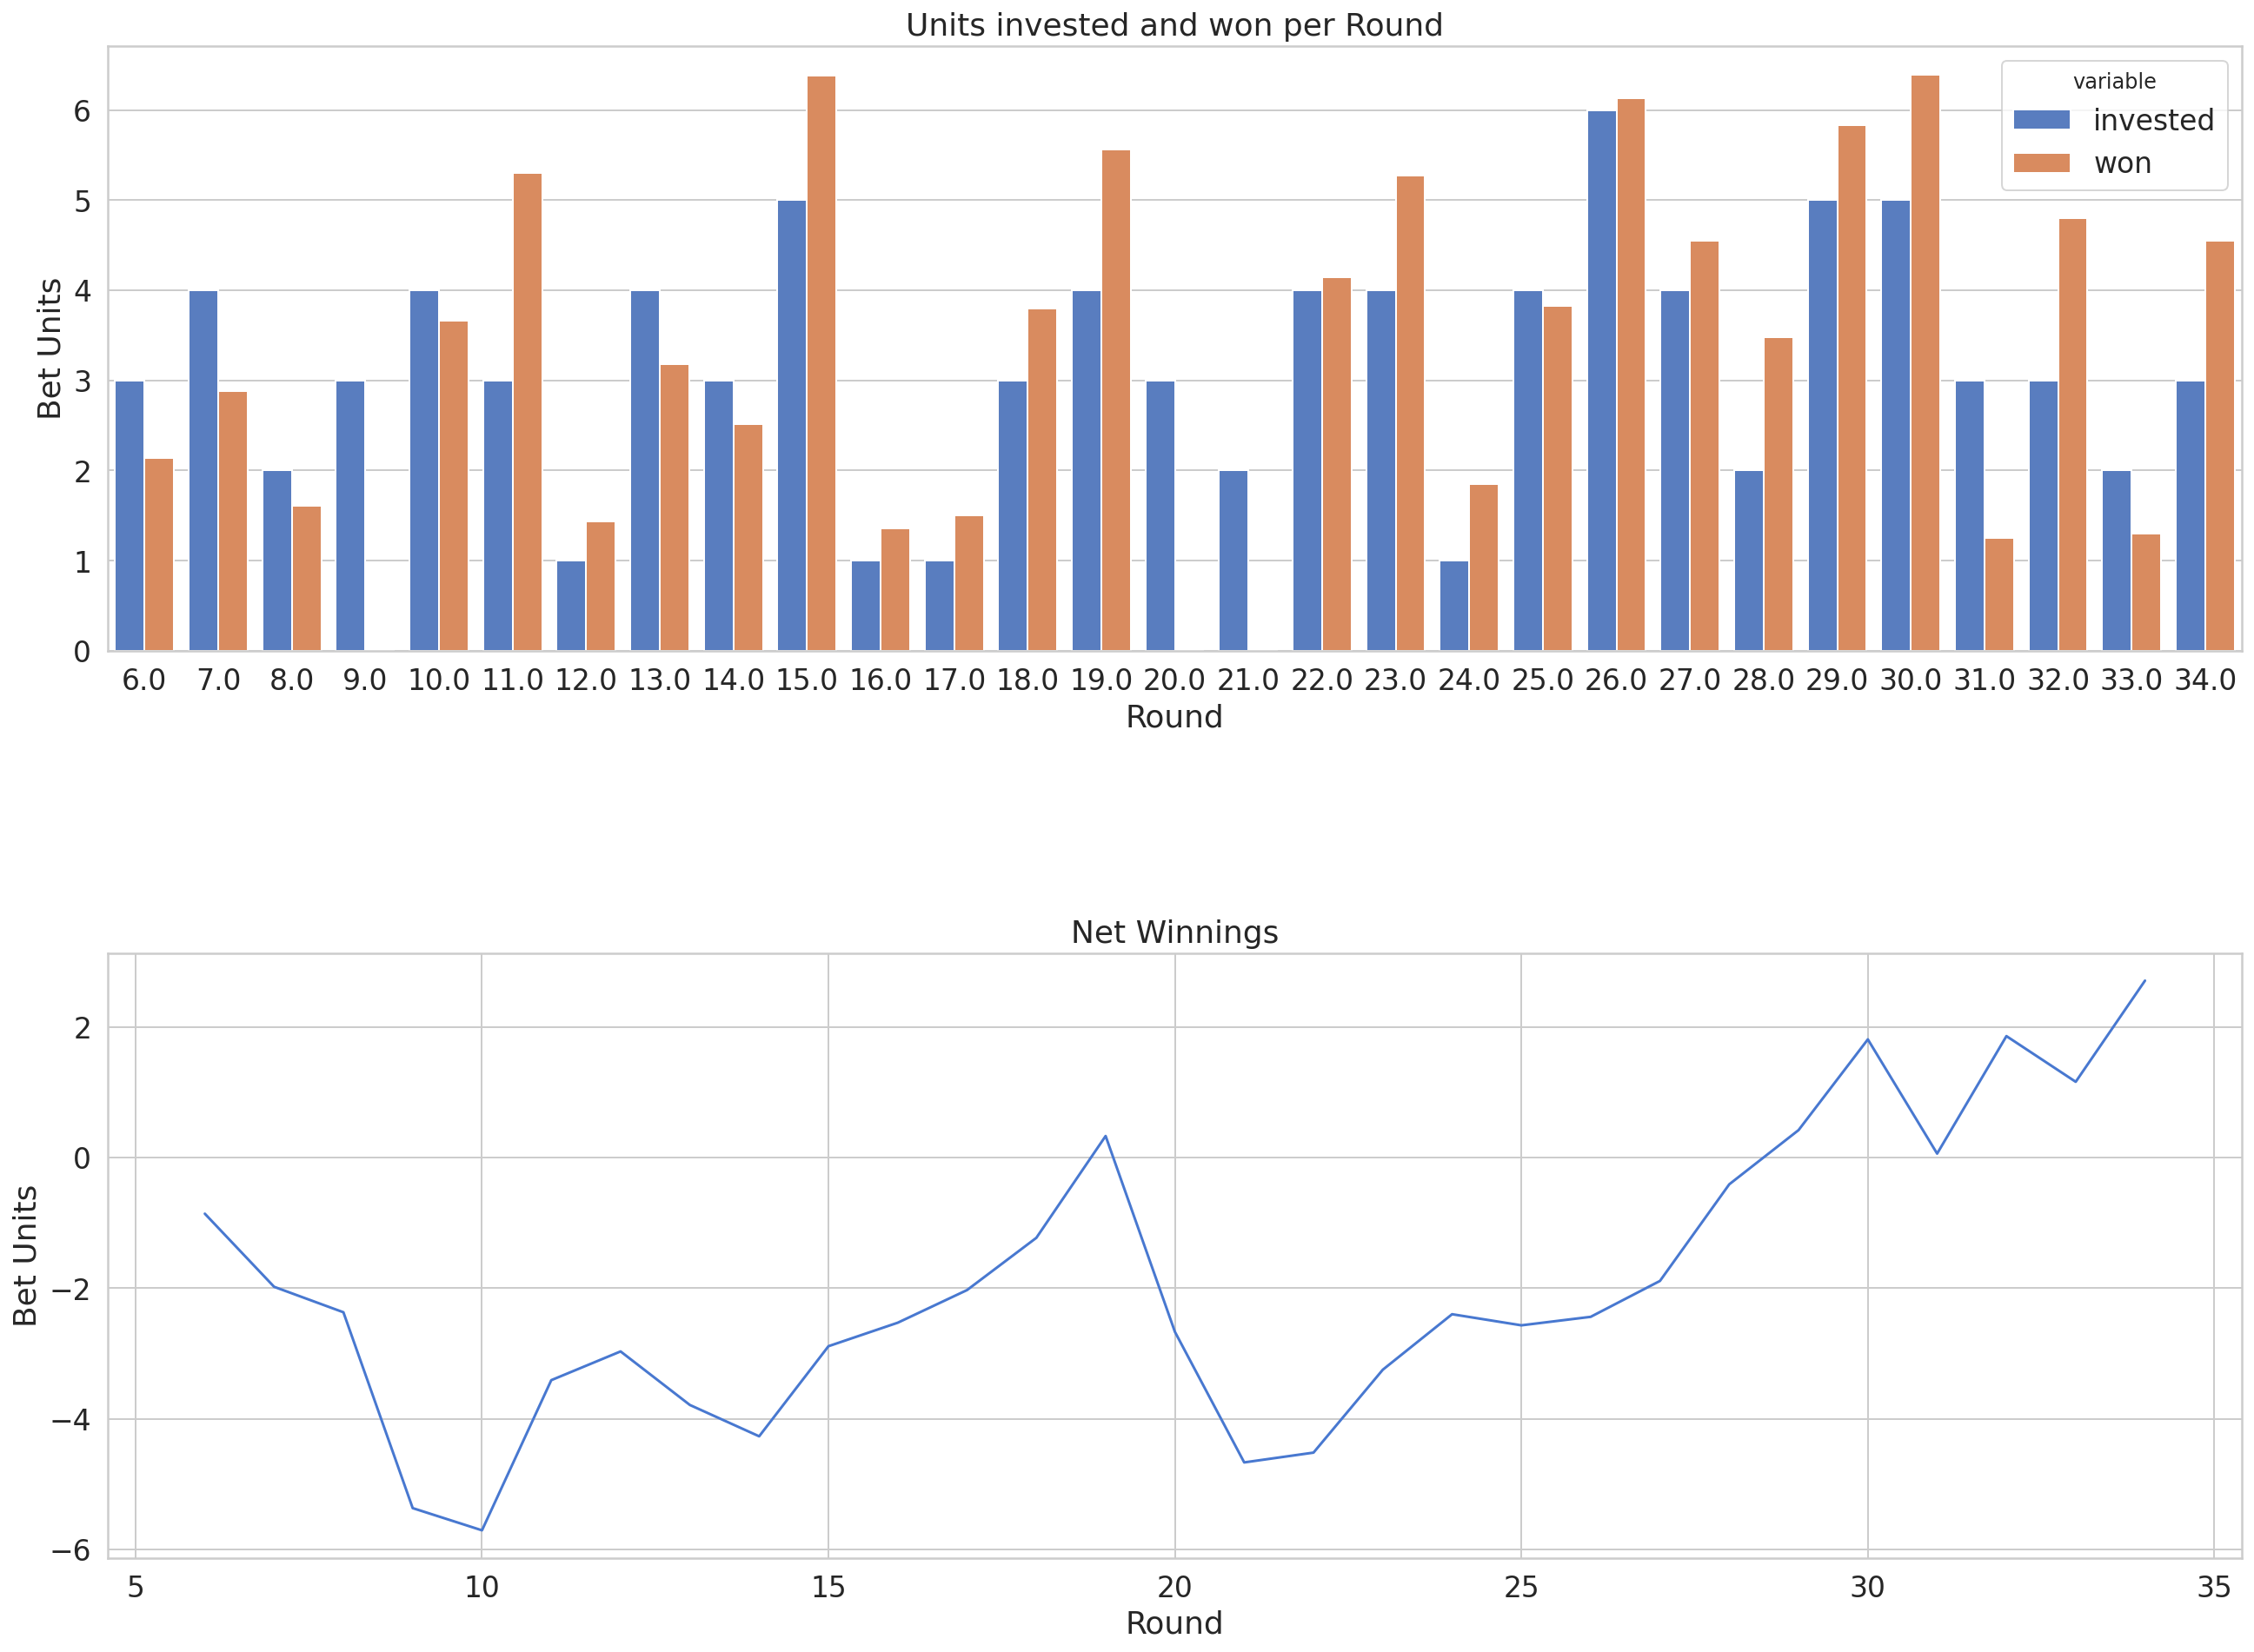

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2)
fig.set_size_inches(22,16)

sns.barplot(x='Round', y='value', hue='variable', data =df_by_round, ax=ax1)
ax1.set_title('Units invested and won per Round')
ax1.set_ylabel('Bet Units')

sns.lineplot(x='Round', y='net_winnings', data =df_winnings_by_round, ax=ax2)
ax2.set_title('Net Winnings')
ax2.set_ylabel('Bet Units')

plt.subplots_adjust(hspace=0.5)